# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.319949,True,5.882584
1,0.440958,True,4.622104
2,-0.880456,False,0.734731
3,1.352040,False,2.243402
4,-0.119246,True,5.176788
...,...,...,...
995,0.223470,False,1.116045
996,0.450676,True,6.721430
997,0.814874,True,4.027162
998,1.359336,True,7.286949


<Axes: xlabel='v0'>

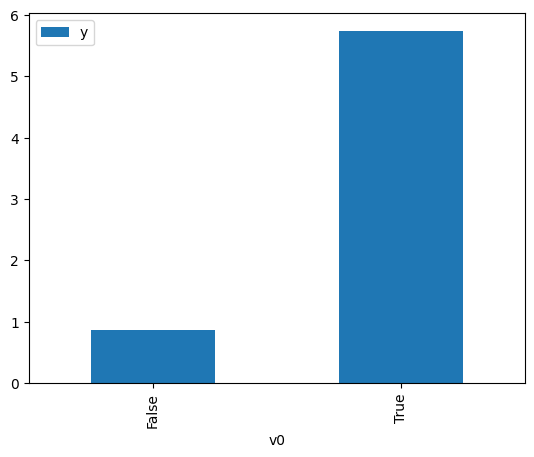

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

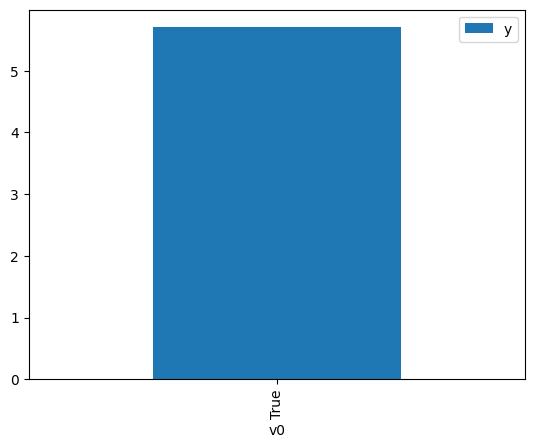

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.259164,False,-1.025702,0.499463,2.002150
1,0.330791,False,1.201951,0.492570,2.030169
2,0.289888,False,0.844696,0.496506,2.014074
3,1.543579,False,0.812667,0.378333,2.643175
4,0.037070,False,0.141225,0.520827,1.920024
...,...,...,...,...,...
995,-0.448824,False,-0.357686,0.567196,1.763060
996,0.934334,False,2.766019,0.434853,2.299629
997,-0.348975,False,0.473715,0.557736,1.792964
998,0.821882,False,0.798649,0.445521,2.244566


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,3.516035,True,9.864709,0.778337,1.284791
1,-0.783727,True,3.441380,0.401468,2.490858
2,-0.559160,True,1.803474,0.422408,2.367380
3,-0.010100,True,4.910736,0.474643,2.106847
4,1.094514,True,4.930522,0.580237,1.723434
...,...,...,...,...,...
995,1.607544,True,5.726897,0.627441,1.593774
996,0.237660,True,5.249902,0.498467,2.006150
997,-0.226316,True,4.621072,0.453942,2.202925
998,-1.045048,True,4.631207,0.377551,2.648650


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                              8904.
Date:                Thu, 12 Feb 2026   Prob (F-statistic):                        0.00
Time:                        23:22:09   Log-Likelihood:                         -1459.8
No. Observations:                1000   AIC:                                      2924.
Df Residuals:                     998   BIC:                                      2933.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0730      0.031     34.403      0.000       1.012       1.134
x2             4.9654      0.052     96.222      0.000       4.864       5.067
==============================================================================
Omnibus:                        0.793   Durbin-Watson:                   2.074
Prob(Omnibus):                  0.673   Jarque-Bera (JB):                0.684
Skew:                          -0.054   Prob(JB):                        0.711
Kurtosis:                       3.068   Cond. No.                         2.11
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""